In [31]:
%run "libraries.ipynb"

from IPython.display import display, HTML
from IPython.html import widgets
import matplotlib.patheffects as path_effects

common libraries loaded


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
pages = codecs.open("data/pagenames.txt","r", "utf-8-sig").readlines()
pages = map(lambda x: x.strip(), pages)

## transformation of the LSM mean matrix to a directed graph

In [28]:
lsm = pd.DataFrame.from_csv("data/pages-lsm_mean.csv", encoding="utf8")

In [29]:
g = nx.DiGraph()

nb_out = 5

for u in lsm.index:
    n = sorted(lsm[u].to_dict().items(), key=lambda x: -x[1])
    n = [ x for x in n if x[0] != u ]
    
    for v in n[0:nb_out]:
        g.add_edge(u, v[0], lsm=float(v[1]))

print "nodes: %s" % len(g.nodes())
print "edges: %s" % len(g.edges())

nodes: 303
edges: 1515


In [34]:
nx.write_gexf(g, "data/reading_maps/lsm5.gexf")

## community detection

In [32]:
import community
partitions = community.best_partition(g.to_undirected())

In [33]:
def print_groups(communities):
    html = "<table>"

    for c, ps in communities.iteritems():
        html += "<tr><td style=\"width: 100px; text-align: center; \"><h3>group %s</h3></td><td>" % (c)
        html += ", ".join(map(lambda x: u"<a href=\"http://en.wikipedia.org/wiki/{0}\" target=\"_blank\">{0}</a>".format(x), ps))
        html += "</td></tr>"
    
    html += "</table>"

    display(HTML(html))
        
communities = {}
for k, v in partitions.iteritems():
    communities.setdefault(v, []).append(k)


print_groups(communities)

## subgraph explorer

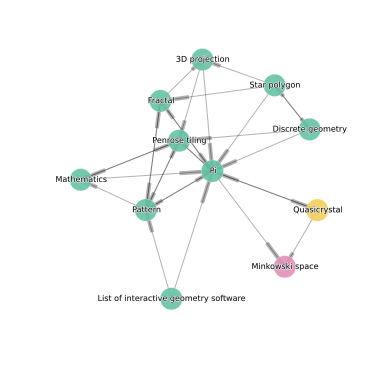

In [35]:
%config InlineBackend.figure_formats=['svg']

def map_colors(g ,partitions):
    size = np.max( [ x[1] for x in partitions.iteritems() ])
    
    for n in partitions:
        g.node[n]["color"] = float(partitions[n])/float(size)


map_colors(g, partitions)

pages = g.nodes()
pages = sorted(pages)

color_map = plt.get_cmap("Set2")
# color_map = sns.color_palette("Set2", 11)

print color_map
def display_local_graph(page):
    nbunch = [ page ]
    nbunch.extend( list(g.to_undirected()[page]))
    g_sub = g.subgraph(nbunch)

    #nx.draw_spring(g2)
    pos = nx.spring_layout(g_sub,iterations=150)
   
    plt.figure(figsize=(6,6))

    colors = map(lambda x: g.node[x]["color"], g_sub.nodes())
    
    # draw nodes
    nodes = nx.draw_networkx_nodes(g_sub, pos, alpha=0.9, node_size=500, node_color=colors, cmap=color_map, vmin=0, vmax=1)
    nodes.set_edgecolor('w')

    # draw edges
    nx.draw_networkx_edges(g_sub, pos, alpha=0.3, width=1)
    
    # draw labels
    labels = nx.draw_networkx_labels(g_sub, pos, font_size=8, font_family="Bitstream Vera Sans")
    map(lambda x: labels[x].set_path_effects([path_effects.Stroke(linewidth=1, foreground='white'),
                       path_effects.Normal()]),labels)
    
    plt.axis('off')
    plt.show()


w = widgets.Select(description="page", options=pages)
widgets.interact(display_local_graph, page=w);